In [2]:
from collections import Counter
import os
import re

from huggingface_hub import login
from transformers import AutoTokenizer, pipeline
from datasets import load_dataset, concatenate_datasets, DatasetDict, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm

/home/wolfingten/.python_environments/ML/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/wolfingten/.python_environments/ML/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/wolfingten/.python_environments/ML/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [85]:
# authentication with huggingface
# !pip install ipywidgets
# request data access at https://huggingface.co/datasets/Cofacts/line-msg-fact-check-tw
# create token at https://huggingface.co/settings/tokens (create as read)
# token should be stored locally, so technically login is only needed one time

TOK_PATH = "/home/wolfingten/.cache/huggingface/token"

with open(TOK_PATH, "r", encoding="utf8") as f:
    token = f.read().strip()

login(token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/wolfingten/.cache/huggingface/token
Login successful


In [2]:
# download specific dataset files; entire archive is only ~250 mb
articles = load_dataset("Cofacts/line-msg-fact-check-tw", "articles") # article contents and some meta info
article_replies = load_dataset("Cofacts/line-msg-fact-check-tw", "article_replies") # 'join table' for articles and replies with added meta info
article_categories = load_dataset("Cofacts/line-msg-fact-check-tw", "article_categories")

art_rep_df = pd.merge(
    articles["train"].to_pandas(),
    article_replies["train"].to_pandas(),
    left_on="id",
    right_on="articleId",
    how="inner"
)

art_rep_cat_df = pd.merge(
    art_rep_df,
    article_categories["train"].to_pandas(),
    left_on="id",
    right_on="articleId",
    how="inner"
)

art_rep_cat_df.head()
# replyType is the label assigned to an article by human editor

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,categoryId,aiConfidence,aiModel,userIdsha,appId,negativeFeedbackCount_y,positiveFeedbackCount_y,status,createdAt,updatedAt
0,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,medical,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-09-05T06:14:26.748Z,2022-09-05T06:14:26.748Z
1,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,covid19,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-09-05T06:14:27.657Z,2022-09-05T06:14:27.657Z
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班\n\n2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,1.0,bow,11db1c28d9380b6b177b0e5646faa60f7df687c5edaf4c...,DEVELOPMENT_BACKEND,0,0,NORMAL,2021-11-21T17:34:28.958Z,2021-11-21T17:34:28.958Z
3,my5ep5z69tql,TEXT,NORMAL,你好👱🏻‍♀️\n\n簡單跟你說一下公司工作內容：\n我們是做購物系統訂單的工作，主要就是增...,1.0,2022-08-11T20:53:15.644Z,2022-08-11T20:53:15.644Z,2022-09-07T11:02:00.344Z,8a8a319bea0b3bff580d8507ae6470ba37e87791171886...,RUMORS_LINE_BOT,...,nD2n7nEBrIRcahlYwQoW,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-08-12T05:52:28.775Z,2022-08-12T05:52:28.775Z
4,3dnh713ikpf3c,TEXT,NORMAL,先和你簡單介紹\n我們誠徵線上打工小幫手\n工作內容有：聽寫打字、頁面排版、商品評論刷流量、...,1.0,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.761Z,47e90b2538a5615b323f50571b77d91f7f105e55684aa1...,RUMORS_LINE_BOT,...,nD2n7nEBrIRcahlYwQoW,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-09-08T05:31:35.081Z,2022-09-08T05:31:35.081Z


In [68]:
# intl
# oT2o7nEBrIRcahlYKQoM
# kj287XEBrIRcahlYvQoS

# lj2m7nEBrIRcahlY6Ao_ (maybe)

political = ["intl", "oT2o7nEBrIRcahlYKQoM", "kj287XEBrIRcahlYvQoS"]
political_cofacts = art_rep_cat_df[art_rep_cat_df["categoryId"].isin(political)]
political_cofacts = political_cofacts[political_cofacts["articleType"] == "TEXT"]
political_cofacts = political_cofacts[political_cofacts["replyType"].isin(["RUMOR", "NOT_RUMOR"])]
political_cofacts = political_cofacts[["id", "text", "replyType"]]
political_cofacts = political_cofacts.drop_duplicates()
len(political_cofacts)

6859

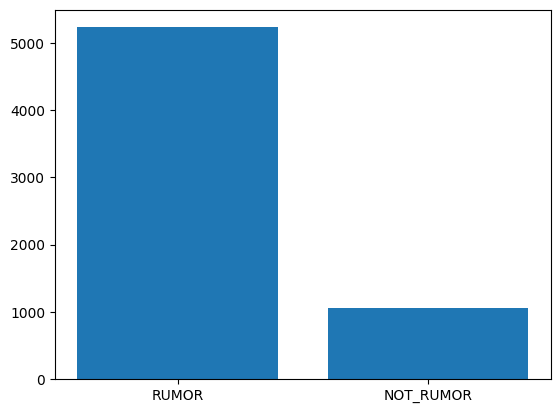

replyType
RUMOR        5229
NOT_RUMOR    1059
Name: count, dtype: int64


In [46]:
# imbalance
lab_counts = political_cofacts["replyType"].value_counts()
plt.bar(lab_counts.index, lab_counts.values)
plt.show()
print(lab_counts)

In [32]:
def get_max_length(texts: list):
    max_length = 0
    for t in texts:
        if t:
            max_length = max(max_length, len(t))
    return max_length

def inspect_dist(col: list, threshold = 0):
    if threshold == 0:
        plt.hist(col, bins=100)
        plt.show()
    else:
        plt.hist(col[col <= threshold], bins=100)
        plt.show()
        print(f"Remaining datapoints: {len(col[col <= threshold]) / len(col)}")

In [33]:
get_max_length(political_cofacts["text"])

10000

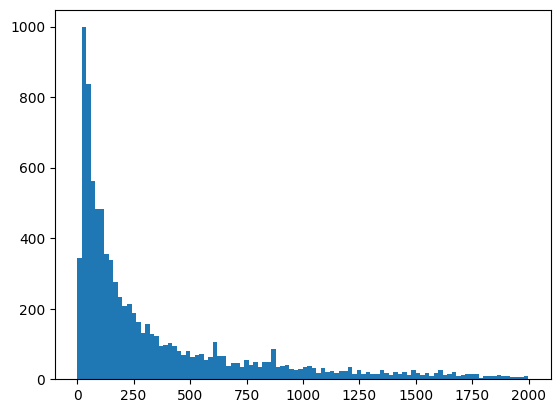

Remaining datapoints: 1.0


In [39]:
inspect_dist(political_cofacts["text"].dropna().apply(len), threshold=2000)

In [14]:
political_cofacts[political_cofacts["text"].str.len() == 28]
# NOTE: remove urls

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,categoryId,aiConfidence,aiModel,userIdsha,appId,negativeFeedbackCount_y,positiveFeedbackCount_y,status,createdAt,updatedAt
352,382yifa6357oz,TEXT,NORMAL,中國大陸的拖吊車！\n看看人家多進步….台灣真是井底之蛙！,1.0,2022-09-01T04:59:46.953Z,2022-09-01T04:59:46.953Z,2022-09-02T14:59:23.980Z,1c0dbb74934331bf03405ab871e6b429a697cbf06e611b...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-09-01T12:01:45.563Z,2022-09-01T12:01:45.563Z
417,105rgiyskma65,TEXT,NORMAL,https://youtu.be/Eldm7ZaXfN0,1.0,2022-09-04T05:10:20.725Z,2022-09-04T05:10:20.725Z,2022-09-06T00:10:55.219Z,b9b3ec3efb9a9632ab92a62e3c01865f62578d2db10bb4...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,3394772103f66782649fa537b40a9dc3346e2f562f42a4...,WEBSITE,0,0,NORMAL,2022-09-04T11:24:48.765Z,2022-09-04T11:24:48.765Z
418,105rgiyskma65,TEXT,NORMAL,https://youtu.be/Eldm7ZaXfN0,1.0,2022-09-04T05:10:20.725Z,2022-09-04T05:10:20.725Z,2022-09-06T00:10:55.219Z,b9b3ec3efb9a9632ab92a62e3c01865f62578d2db10bb4...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,NaN,None,3394772103f66782649fa537b40a9dc3346e2f562f42a4...,WEBSITE,0,0,NORMAL,2022-09-04T11:24:54.920Z,2022-09-04T11:24:54.920Z
712,324p4t3ostnfv,TEXT,NORMAL,https://youtu.be/BycaC5FxgiE,1.0,2022-07-21T01:39:17.373Z,2022-07-21T01:39:17.373Z,2022-07-28T11:45:24.054Z,16b9f4cf813f55ea6186ed007b07d46b821f4cc329f885...,RUMORS_LINE_BOT,...,intl,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-07-21T16:30:47.171Z,2022-07-21T16:30:47.171Z
713,324p4t3ostnfv,TEXT,NORMAL,https://youtu.be/BycaC5FxgiE,1.0,2022-07-21T01:39:17.373Z,2022-07-21T01:39:17.373Z,2022-07-28T11:45:24.054Z,16b9f4cf813f55ea6186ed007b07d46b821f4cc329f885...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-07-21T16:30:47.776Z,2022-07-21T16:30:47.776Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95867,2w7q7vuv04c8i,TEXT,NORMAL,https://youtu.be/eTaLYsImkWc,1.0,2022-05-02T11:53:13.469Z,2022-05-02T11:53:13.469Z,2022-08-05T05:28:39.858Z,cf57f5ffabfa470975ba1260f6de7ca0199f1429aaf179...,RUMORS_LINE_BOT,...,intl,NaN,None,3394772103f66782649fa537b40a9dc3346e2f562f42a4...,WEBSITE,0,1,NORMAL,2022-05-04T12:19:48.063Z,2022-05-04T12:19:48.063Z
96027,1qm4jttwezxwc,TEXT,NORMAL,有夠離譜，從紙箱夾層拉出一大堆票！有請大家廣發揭露！！！,1.0,2024-01-19T06:41:52.059Z,2024-01-19T06:41:52.059Z,2024-01-19T06:41:52.069Z,e9d23c5fbae20f47911888299fe2a1f9dc009455f5e289...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,WEBSITE,0,0,NORMAL,2024-01-19T14:43:59.257Z,2024-01-19T14:43:59.257Z
96994,2nn9hdhq0i5ds,TEXT,NORMAL,全世界都知道賴清德養小三叫莊雅芬、生了一個私生子叫賴庭瀚,1.0,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.298Z,ba2fe1c2638275dde1c566a384aa2f4d9f88940ef61191...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,WEBSITE,0,0,NORMAL,2024-01-03T14:05:32.284Z,2024-01-03T14:05:32.284Z
96995,2nn9hdhq0i5ds,TEXT,NORMAL,全世界都知道賴清德養小三叫莊雅芬、生了一個私生子叫賴庭瀚,1.0,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.298Z,ba2fe1c2638275dde1c566a384aa2f4d9f88940ef61191...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,WEBSITE,0,0,NORMAL,2024-01-03T14:05:32.284Z,2024-01-03T14:05:32.284Z


In [69]:
def remove_url(text: str):
    regex = r"https?\S+|\S*\.com\S*"
    text = re.sub(regex, "", text).strip()
    if len(text) == 0:
        text = pd.NA
    return text

political_cofacts["text"] = political_cofacts["text"].apply(remove_url)
political_cofacts = political_cofacts.dropna()
political_cofacts = political_cofacts[(political_cofacts["text"].str.len() <= 2000) & (political_cofacts["text"].str.len() >= 10)]

label_mapping = {
    "NOT_RUMOR": 0,
    "RUMOR": 1
    }

political_cofacts["label"] = political_cofacts['replyType'].replace(label_mapping)
political_cofacts = political_cofacts[["text", "label"]]
political_cofacts = political_cofacts.reset_index(drop=True)

In [81]:
val_test_ratio = 0.2

train_split, val_test_split = train_test_split(
    political_cofacts,
    test_size=val_test_ratio,
    stratify=political_cofacts['label'],
    random_state=42)

val_split, test_split = train_test_split(
    val_test_split,
    test_size=0.5,
    stratify=val_test_split['label'],
    random_state=42)

dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(train_split),
    'validation': Dataset.from_pandas(val_split),
    'test': Dataset.from_pandas(test_split)
})

for split in dataset_dict.keys():
    dataset_dict[split] = dataset_dict[split].remove_columns("__index_level_0__")

In [ ]:
login()

In [89]:
dataset_dict.push_to_hub("FNHQ/cofacts", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/FNHQ/cofacts/commit/f98ec1504e264c6b0f19e826485a9cdd37a26a68', commit_message='Upload dataset', commit_description='', oid='f98ec1504e264c6b0f19e826485a9cdd37a26a68', pr_url=None, pr_revision=None, pr_num=None)

In [11]:
# https://symbl.cc/en/unicode/blocks/

# retain
# chinese block: \u4E00-\u9FFF
# cjk punctuation: \u3000-\u303F
# ascii block: \u0000-\u007F
# general punctuation: \u2000-\u206F
# halfwidth punctuation: \uFF00-\uFF65

# preserve other scripts? (japanese, korean, thai, ...)
# presentation form punctuation: \uFE00-\uFFFF
# mathematical operators: \u2200-\u22FF

# discard
# \u1F000-\u1FBFF
# dingdats: \u2700-\u27BF
# emojis: \u1F600-\u1F64F

In [12]:
### Preprocessing so far
def filter_unicodes(texts: list):
    retain = list()
    remove = list()
    for t in texts:
        if pd.notna(t):
            regex = re.compile(r"[^\u4E00-\u9FFF\u3000-\u303F\u0000-\u007F\u2000-\u206F\uFF00-\uFF65]")
            filtered_txt = regex.sub("", t)
            retain.append(filtered_txt)
            deleted = regex.findall(t)
            remove.append(deleted)
        else:
            retain.append(t)
    remove = Counter([i for l in remove for i in l])
    return retain, remove

def find_unicodes(chars: list):
    out = {char : char.encode("unicode_escape") for char in chars}
    return out

# processing steps
clean_df = political_cofacts.copy()
clean_df["text"], remove = filter_unicodes(clean_df["text"]) # filter for chinese and latin script
clean_df = clean_df.dropna()
clean_df.head()
# still some user ids, urls with uncommon domains

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,categoryId,aiConfidence,aiModel,userIdsha,appId,negativeFeedbackCount_y,positiveFeedbackCount_y,status,createdAt,updatedAt
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班 2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，我站...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,1.0,bow,11db1c28d9380b6b177b0e5646faa60f7df687c5edaf4c...,DEVELOPMENT_BACKEND,0,0,NORMAL,2021-11-21T17:34:28.958Z,2021-11-21T17:34:28.958Z
12,2gf5rwls4alux,TEXT,NORMAL,柬埔寨活摘器官像屠宰場難以想像告訴周圍的朋友別為了錢去柬埔寨,2.0,2022-08-13T07:08:52.929Z,2022-08-13T07:08:52.929Z,2022-08-13T07:08:52.950Z,17157db98067221ce5bc87e2cfd6aa140db2ae7a5aba05...,RUMORS_LINE_BOT,...,intl,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-08-13T15:36:22.208Z,2022-08-13T15:36:22.208Z
20,1be7unngzm4hj,TEXT,NORMAL,［重要消息］ 以下國家宣布取消所有檢疫程序、新冠病毒檢測和強制接種疫苗，並認為新冠病毒只是...,2.0,2022-02-03T13:25:32.338Z,2022-02-03T13:25:32.338Z,2022-02-03T15:45:44.906Z,862d08a9739e3b750cc428fc11c1cd7c19411cea79a832...,RUMORS_LINE_BOT,...,intl,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-02-03T13:40:22.100Z,2022-02-03T13:40:22.100Z
22,1be7unngzm4hj,TEXT,NORMAL,［重要消息］ 以下國家宣布取消所有檢疫程序、新冠病毒檢測和強制接種疫苗，並認為新冠病毒只是...,2.0,2022-02-03T13:25:32.338Z,2022-02-03T13:25:32.338Z,2022-02-03T15:45:44.906Z,862d08a9739e3b750cc428fc11c1cd7c19411cea79a832...,RUMORS_LINE_BOT,...,intl,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-02-03T13:40:22.100Z,2022-02-03T13:40:22.100Z
23,3h85z5df0rcgq,TEXT,NORMAL,"CDC已承認失敗！！！ 事到如今，我们该何去何从？ 斯图尔特坦克斯利博士： ""科学已經很明...",1.0,2022-08-27T03:24:59.219Z,2022-08-27T03:24:59.219Z,2022-08-27T03:24:59.243Z,993c8c5b07c5db250f3cc27cd6fab5d95b5edab4681d34...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,NaN,None,3394772103f66782649fa537b40a9dc3346e2f562f42a4...,WEBSITE,0,0,NORMAL,2022-08-29T13:54:36.342Z,2022-08-29T13:54:36.342Z


In [13]:
find_unicodes([c[0] for c in remove.most_common()])

{'﹔': b'\\ufe54',
 '﹐': b'\\ufe50',
 'о': b'\\u043e',
 '⋯': b'\\u22ef',
 'а': b'\\u0430',
 '\xa0': b'\\xa0',
 'т': b'\\u0442',
 'е': b'\\u0435',
 'с': b'\\u0441',
 'и': b'\\u0438',
 'н': b'\\u043d',
 'р': b'\\u0440',
 'в': b'\\u0432',
 '️': b'\\ufe0f',
 'у': b'\\u0443',
 'м': b'\\u043c',
 '·': b'\\xb7',
 'д': b'\\u0434',
 'к': b'\\u043a',
 'п': b'\\u043f',
 'い': b'\\u3044',
 'б': b'\\u0431',
 'л': b'\\u043b',
 'に': b'\\u306b',
 'я': b'\\u044f',
 'の': b'\\u306e',
 'г': b'\\u0433',
 'な': b'\\u306a',
 '\ufeff': b'\\ufeff',
 'と': b'\\u3068',
 'を': b'\\u3092',
 'ㄧ': b'\\u3127',
 'す': b'\\u3059',
 'ю': b'\\u044e',
 'で': b'\\u3067',
 'ь': b'\\u044c',
 '─': b'\\u2500',
 '﹗': b'\\ufe57',
 'た': b'\\u305f',
 'ы': b'\\u044b',
 'ﻫ': b'\\ufeeb',
 'か': b'\\u304b',
 'て': b'\\u3066',
 'з': b'\\u0437',
 'こ': b'\\u3053',
 'ま': b'\\u307e',
 '￼': b'\\ufffc',
 'し': b'\\u3057',
 'は': b'\\u306f',
 '⃣': b'\\u20e3',
 '○': b'\\u25cb',
 'й': b'\\u0439',
 'も': b'\\u3082',
 'が': b'\\u304c',
 'ш': b'\\u0448',
 'ч': 

In [22]:
### putting it all together
def filter_unicodes(text: str):
    if pd.notna(text):
        text = re.sub("\n", " ", text)
        regex_urls = r"https?\S+|\S*\.com\S*"
        text = re.sub(regex_urls, "", text)
        text = text.strip()
        if text:
            regex_han_ascii = re.compile(r"[^\u4E00-\u9FFF\u3000-\u303F\u0000-\u007F\u2000-\u206F\uFF00-\uFF65]")
            text = regex_han_ascii.sub("", text)
            if not text:
                text = pd.NA
        else:
            text = pd.NA
    return text


#label_dict = {
#    "NOT_RUMOR": 0,
#    "OPINIONATED" : 1,
#    "RUMOR" : 2
#}
#
#political_cofacts["label"] = political_cofacts["replyType"].map(label_dict)
political_cofacts["text"] = political_cofacts["text"].apply(filter_unicodes)
political_cofacts = political_cofacts.dropna(subset=["text", "replyType"])
political_cofacts.head()

,id,text,replyType
2,oupi0eu9aocr,被取消的航班 2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，我站...,OPINIONATED
12,2gf5rwls4alux,柬埔寨活摘器官像屠宰場難以想像告訴周圍的朋友別為了錢去柬埔寨,RUMOR
20,1be7unngzm4hj,［重要消息］ 以下國家宣布取消所有檢疫程序、新冠病毒檢測和強制接種疫苗，並認為新冠病毒只是...,RUMOR
22,1be7unngzm4hj,［重要消息］ 以下國家宣布取消所有檢疫程序、新冠病毒檢測和強制接種疫苗，並認為新冠病毒只是...,RUMOR
23,3h85z5df0rcgq,"CDC已承認失敗！！！ 事到如今，我们该何去何从？ 斯图尔特坦克斯利博士： ""科学已經很明...",RUMOR


### upload liar to huggingface

In [4]:
file_names = ["train.pkl", "validation.pkl", "test.pkl"]

liar_dict = DatasetDict()
for name in file_names:  
  with open("pickle_files/" + name, "rb") as f:
    data = pickle.load(f)
    liar_dict[name.split(".")[0]] = Dataset.from_pandas(data)

In [5]:
liar_dict.push_to_hub("FNHQ/liar-sentiment-perplexity", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/FNHQ/liar-sentiment-perplexity/commit/3ef52bf33e0bdcc71b9ef2d5d36a9c9444a9c457', commit_message='Upload dataset', commit_description='', oid='3ef52bf33e0bdcc71b9ef2d5d36a9c9444a9c457', pr_url=None, pr_revision=None, pr_num=None)

In [8]:
liar_dict.select_columns(["statement", "label"])

DatasetDict({
    train: Dataset({
        features: ['statement', 'label'],
        num_rows: 10269
    })
    validation: Dataset({
        features: ['statement', 'label'],
        num_rows: 1284
    })
    test: Dataset({
        features: ['statement', 'label'],
        num_rows: 1283
    })
})

In [95]:
liar_ds = load_dataset("FNHQ/liar-sentiment-perplexity")

In [98]:
liar_ds["train"]["perplexity"]

[2.338595151901245,
 1.6680935621261597,
 1.9249241352081299,
 2.172579050064087,
 3.380251407623291,
 1.5534826517105103,
 2.5549476146698,
 1.4950398206710815,
 1.5851905345916748,
 1.6481260061264038,
 1.8437556028366089,
 2.312971830368042,
 1.7387524843215942,
 2.5786304473876953,
 2.062774658203125,
 1.3804751634597778,
 1.6406822204589844,
 1.5552151203155518,
 1.6817312240600586,
 2.834785223007202,
 1.7830171585083008,
 2.3193514347076416,
 2.4120235443115234,
 2.2029366493225098,
 2.517167329788208,
 3.4022326469421387,
 2.4113168716430664,
 1.815245509147644,
 1.6970117092132568,
 3.0376780033111572,
 3.0484752655029297,
 1.739572525024414,
 1.4544166326522827,
 2.4940145015716553,
 2.935795783996582,
 2.370335340499878,
 2.077000141143799,
 1.4280034303665161,
 1.637368083000183,
 1.7326948642730713,
 1.6940910816192627,
 2.0674686431884766,
 1.8023695945739746,
 1.634521722793579,
 1.6044862270355225,
 2.538452625274658,
 1.9186680316925049,
 2.3590168952941895,
 1.6061353

### Add sentiment to cofacts

In [2]:
cofacts_ds = load_dataset("FNHQ/cofacts")

In [2]:
tokenizer = AutoTokenizer.from_pretrained(
    "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
    )

pipe = pipeline(
    "text-classification",
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer=tokenizer
    )

In [91]:
for split in cofacts_ds.keys():
    col = []
    for txt in tqdm(cofacts_ds[split]["text"]):
        sentiment = pipe(txt, truncation=True, max_length=512, return_all_scores=True)
        sentiment = [item["score"] for item in sentiment[0]]
        col.append(sentiment)
    cofacts_ds[split] = cofacts_ds[split].add_column("sentiment", col)

  0%|          | 0/5030 [00:00<?, ?it/s]/home/wolfingten/.python_environments/ML/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 629/629 [00:53<00:00, 11.71it/s]


In [93]:
login()

In [94]:
cofacts_ds.push_to_hub("FNHQ/cofacts", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/FNHQ/cofacts/commit/efd621460f2d483aaffb2fd716608eebb354eebb', commit_message='Upload dataset', commit_description='', oid='efd621460f2d483aaffb2fd716608eebb354eebb', pr_url=None, pr_revision=None, pr_num=None)

In [13]:
cofacts_ds = load_dataset("FNHQ/cofacts")
undersampled_ds = DatasetDict()

In [68]:
split = "test"

df = cofacts_ds[split].to_pandas()

min_count = min(df["label"].value_counts())
fake_df = df[df["label"] == 1]
fake_df = fake_df.sort_values(by="text", key=lambda x: x.str.len(), ascending=False)
fake_df = fake_df.head(min_count)
true_df = df[df["label"] == 0]
undersampled_df = pd.concat([fake_df, true_df])
ds = Dataset.from_pandas(undersampled_df)

undersampled_ds[split] = ds


In [69]:
undersampled_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'sentiment', '__index_level_0__'],
        num_rows: 1694
    })
    validation: Dataset({
        features: ['text', 'label', 'sentiment', '__index_level_0__'],
        num_rows: 212
    })
    test: Dataset({
        features: ['text', 'label', 'sentiment', '__index_level_0__'],
        num_rows: 212
    })
})

In [71]:
undersampled_ds = undersampled_ds.select_columns(["text", "label", "sentiment"])

In [72]:
undersampled_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 1694
    })
    validation: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 212
    })
    test: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 212
    })
})

In [73]:
undersampled_ds.push_to_hub("FNHQ/cofacts_undersampled", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/FNHQ/cofacts_undersampled/commit/6c91070258f49c52a02dc5eca04af3b4c69ec523', commit_message='Upload dataset', commit_description='', oid='6c91070258f49c52a02dc5eca04af3b4c69ec523', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
mcfend = pd.read_csv("./data/mcfend/news.csv", usecols=["label", "title", "content", "news_id"])
mcfend = mcfend.drop_duplicates().dropna()
mcfend["text"] = mcfend["title"].astype(str) + mcfend["content"].astype(str)
mcfend.head()
mcfend["label"].value_counts()


label
谣言    5553
事实     961
Name: count, dtype: int64

In [6]:
def remove_url(text: str):
    regex = r"https?\S+|\S*\.com\S*"
    text = re.sub(regex, "", text).strip()
    if len(text) == 0:
        text = pd.NA
    return text

mcfend["text"] = mcfend["text"].apply(remove_url)
mcfend = mcfend.dropna()

label_mapping = {
    "事实": 0, # not rumor
    "谣言": 1  # fake
    }

mcfend["label"] = mcfend["label"].replace(label_mapping)
mcfend = mcfend[["text", "label"]]

In [10]:
# select only true news
mcfend = mcfend[mcfend["label"] == 0]
len(mcfend)

961

In [11]:
col = []
for txt in tqdm(mcfend["text"]):
    sentiment = pipe(txt, truncation=True, max_length=512, return_all_scores=True)
    sentiment = [item["score"] for item in sentiment[0]]
    col.append(sentiment)
mcfend["sentiment"] = col

  0%|          | 0/961 [00:00<?, ?it/s]/home/wolfingten/.python_environments/ML/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 961/961 [00:35<00:00, 26.75it/s]


In [17]:
val_test_ratio = 0.2

train_split, val_test_split = train_test_split(
    mcfend,
    test_size=val_test_ratio,
    stratify=mcfend['label'],
    random_state=42)

val_split, test_split = train_test_split(
    val_test_split,
    test_size=0.5,
    stratify=val_test_split['label'],
    random_state=42)

train_split = concatenate_datasets([cofacts_ds["train"], Dataset.from_pandas(train_split)])
val_split = concatenate_datasets([cofacts_ds["validation"], Dataset.from_pandas(val_split)])
test_split = concatenate_datasets([cofacts_ds["test"], Dataset.from_pandas(test_split)])

augmented_cofacts = DatasetDict({
    "train": train_split,
    "validation": val_split,
    "test": test_split,
})

In [19]:
augmented_cofacts.select_columns(["text", "label", "sentiment"])

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 5798
    })
    validation: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 725
    })
    test: Dataset({
        features: ['text', 'label', 'sentiment'],
        num_rows: 726
    })
})

In [20]:
augmented_cofacts.push_to_hub("FNHQ/cofacts_augmented", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/FNHQ/cofacts_augmented/commit/3e115f83d4f0445645b952ebddd4d0bcc97c9ff8', commit_message='Upload dataset', commit_description='', oid='3e115f83d4f0445645b952ebddd4d0bcc97c9ff8', pr_url=None, pr_revision=None, pr_num=None)

In [14]:
liar_ds = load_dataset("FNHQ/liar-sentiment-perplexity")
augmented_cofacts = load_dataset("FNHQ/cofacts_augmented")

Generating train split:   0%|          | 0/5798 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/725 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/726 [00:00<?, ? examples/s]

In [15]:
augmented_cofacts

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'sentiment', '__index_level_0__'],
        num_rows: 5798
    })
    validation: Dataset({
        features: ['text', 'label', 'sentiment', '__index_level_0__'],
        num_rows: 725
    })
    test: Dataset({
        features: ['text', 'label', 'sentiment', '__index_level_0__'],
        num_rows: 726
    })
})

In [24]:
liar_df = liar_ds["train"].to_pandas()

In [25]:
liar_df["label"].value_counts()

label
1    2123
0    1998
2    1966
3    1683
4    1657
5     842
Name: count, dtype: int64

In [26]:
label_mapping = {
    3: 0, # not rumor
    2: 0,
    0: 1, # fake
    1: 1,
    4: 1,
    5: 1
    }

liar_df["label"] = liar_df["label"].replace(label_mapping)
liar_df["label"].value_counts()

label
1    6620
0    3649
Name: count, dtype: int64

In [28]:
liar_df["text"] = liar_df["statement"]
liar_df = liar_df[["text", "label", "sentiment"]]

In [32]:
min_count = min(liar_df["label"].value_counts())
fake_df = liar_df[liar_df["label"] == 1]
fake_df = fake_df.sort_values(by="text", key=lambda x: x.str.len(), ascending=False)
fake_df = fake_df.head(min_count)
true_df = liar_df[liar_df["label"] == 0]
undersampled_liar = pd.concat([fake_df, true_df])

In [34]:
undersampled_liar["label"].value_counts()

label
1    3649
0    3649
Name: count, dtype: int64

In [36]:
val_test_ratio = 0.2

train_split, val_test_split = train_test_split(
    undersampled_liar,
    test_size=val_test_ratio,
    stratify=undersampled_liar['label'],
    random_state=42)

val_split, test_split = train_test_split(
    val_test_split,
    test_size=0.5,
    stratify=val_test_split['label'],
    random_state=42)

train_split = concatenate_datasets([augmented_cofacts["train"], Dataset.from_pandas(train_split)])
val_split = concatenate_datasets([augmented_cofacts["validation"], Dataset.from_pandas(val_split)])
test_split = concatenate_datasets([augmented_cofacts["test"], Dataset.from_pandas(test_split)])

cofacts_liar = DatasetDict({
    "train": train_split,
    "validation": val_split,
    "test": test_split,
})

In [38]:
cofacts_liar.push_to_hub("FNHQ/cofacts_liar", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/FNHQ/cofacts_liar/commit/485867d86a3cb1af3ca037102ecffd1eeffffe63', commit_message='Upload dataset', commit_description='', oid='485867d86a3cb1af3ca037102ecffd1eeffffe63', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# add true news to cofacts (add sentiment first)
# combine liar + cofacts

In [3]:
ds = load_dataset("FNHQ/liar-sentiment-perplexity")

In [5]:
df = ds["train"].to_pandas()
df["text"] = df["statement"]
df = df[["text", "label", "sentiment", "subject", "speaker", "job_title", "state_info", "party_affiliation", "context"]]
df.head()

,text,label,sentiment,subject,speaker,job_title,state_info,party_affiliation,context
0,Says the Annies List political group supports ...,0,"[0.494022935628891, 0.1540677547454834, 0.3519...",abortion,dwayne-bohac,State representative,Texas,republican,a mailer
1,When did the decline of coal start? It started...,1,"[0.23761452734470367, 0.18118640780448914, 0.5...","energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.
2,"Hillary Clinton agrees with John McCain ""by vo...",2,"[0.5235663652420044, 0.14535528421401978, 0.33...",foreign-policy,barack-obama,President,Illinois,democrat,Denver
3,Health care reform legislation is likely to ma...,0,"[0.4653804898262024, 0.1953166276216507, 0.339...",health-care,blog-posting,,,none,a news release
4,The economic turnaround started at the end of ...,1,"[0.43884366750717163, 0.20763611793518066, 0.3...","economy,jobs",charlie-crist,,Florida,democrat,an interview on CNN
